# Descriptive title that follows notebook filename

**Notebook currently compatible with the `NCI`|`DEA Sandbox` environment only**

### General advice (delete this cell before submitting for review)

- When choosing a location for your analysis, **select an area that has data on both the `NCI` and `DEA Sandbox`** to allow your code to be run on both environments. 
For example, you can check this for Landsat using the [DEA Explorer](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3/1990) (use the drop-down menu to view all products). 
As of September 2019, the `DEA Sandbox` has a single year of continental Landsat data for 2015-16, and the full 1987-onward time-series for three locations (Perth WA, Brisbane QLD, and western NSW).
- When writing in Markdown cells, start each sentence is on a **new line**.
This makes it easy to see changes through git commits.
- Use Australian English in markdown cells and code comments.
- Use the [PEP8 standard](https://www.python.org/dev/peps/pep-0008/) for code. To make sure all code in the notebook is consistent, you can use the `jupyterlab_code_formatter` tool: select each code cell, then click `Edit` and then one of the `Apply X Formatter` options (`YAPF` or `Black` are recommended). This will reformat the code in the cell to a consistent style.
- In the final notebook cell, include a set of relevant tags which are used to build the DEA User Guide's [Tag Index](https://docs.dea.ga.gov.au/genindex.html). 
Use all lower-case, seperate words with spaces, and where possible re-use existing tags.
Ensure the tags cell below is in `Raw` format, rather than `Markdown` or `Code`.


### Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

### Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above, and a run-down of the tools/methods being demonstrated below.


### Technical details
* **Products used:** `product_name`, `product_name`, `product_name`
* **Analyses used:** NDWI water index, geomedian compositing, pixel drill
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook

## Getting started
Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

## Cowell Power Plant Project

Cowell is a coastal town on Franklin Harbor on the eastern side of the Eyre Peninsula, in South Australia 493 km by road from Adelaide. Franklin Harbor is a natural harbour with a channel to the sea just 100 metres wide.

This town is the major population centre of the District Council of Franklin Harbour, and the centre of an agricultural district, farming wheat and sheep. Fishing, and more recently, oyster farming has also been an important industry.

<img src="Cowell_Satellite.png" alt="drawing" width="400" align="left"/>

Cowell has recently attracted the attention of the South Australian government as a potential place to test a promising new technology that allows getting energy from the tides. Franklin Harbour has a narrow channel to the sea through which every day millions of liters of water flow in and out as the tide changes. The people in the town are quite excited with the idea of becoming a major producer of energy in SA and hosting the first tidal clean energy plant in Australia.

### Your task:

You are an engineer working at Tidesla, a new company that has developed a promising technology for building and installing underwater turbines. You have been tasked with finding the best location in Australia to test the technology and you are starting by Cowell. The most urgent matter is getting an estimate about how much energy this plant could generate. You have no previous experience working in tidal power plants but you have heard about Digital Earth Australia and the InterTidal Extents Model (ITEM) product, which presents information of tidal extents in Australia observed from satellites.

Using this dataset you are going to calculate how many liters of water go through the channel every time there is a change of tide. These numbers can then be transformed into KWatts using the efficiency values provided by the turbine development team. 

One of your colleagues has given you the polygon delimiting Franklin Harbour. This polygon cuts the channels at the place where the underwater turbines would be placed. Go to [geojson.io](http://geojson.io) to visualise the polygon. 

**Hint:** *Paste the contents delimited by the outer curly braces, in the next cell, into the right hand side panel of geojson.io webpage.*

In [112]:
poly = """{
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "LineString",
        "coordinates": [
          [
            136.91986083984375,
            -33.66549665763364
          ],
          [
            136.86492919921872,
            -33.71577279930021
          ],
          [
            136.84432983398438,
            -33.75403149821638
          ],
          [
            136.84398651123047,
            -33.798835278253975
          ],
          [
            136.86458587646484,
            -33.79312909288506
          ],
          [
            136.96208953857422,
            -33.745467600106174
          ],
          [
            136.96964263916016,
            -33.738615865848736
          ],
          [
            136.9552230834961,
            -33.73490428127589
          ],
          [
            136.98612213134766,
            -33.693780606387506
          ],
          [
            136.97650909423828,
            -33.667211101197545
          ],
          [
            136.91986083984375,
            -33.66549665763364
          ]
        ]
      }
    }"""

### Getting ready by loading some packages 

Once you have verified the polygon data you decide to load your favorite Python libraries to start working on this project.

In [113]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import json
import sys
import xarray as xr

sys.path.append("../Scripts")
from dea_masking import mask

In [114]:
dc = datacube.Datacube(app="Tidal_powerplant")

### Selecting and loading the data

Getting Cowell's coordinates from Wikipedia you define an extension that covers the entire area around Franklin Harbour.

In [115]:
y = -33.683333
x = 136.916667

query = {'x': (x - .08, x + .1),
         'y': (y - .12, y + 0.03),         
         'crs': 'EPSG:4326'}

# Import ITEM v2.0 relative layer 
item_data = dc.load(product='item_v2', **query)

# Squeeze out the unnecessary temporal dimension:
item_data = item_data.squeeze(dim = 'time', drop = True)

# Filter out -6666 values present in this area
item_data['relative'] = item_data.relative.where(item_data.relative != -6666, 0)

item_data

<xarray.Dataset>
Dimensions:   (x: 690, y: 695)
Coordinates:
  * y         (y) float64 -3.681e+06 -3.681e+06 ... -3.698e+06 -3.698e+06
  * x         (x) float64 4.452e+05 4.453e+05 4.453e+05 ... 4.624e+05 4.625e+05
Data variables:
    relative  (y, x) int16 9 9 9 9 9 9 9 9 9 9 9 9 9 ... 0 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:      EPSG:3577

### Plotting the ITEM Relative Extent data

Using your matplotlib skills you write a function to visualise the extensions exposed at different tide levels.

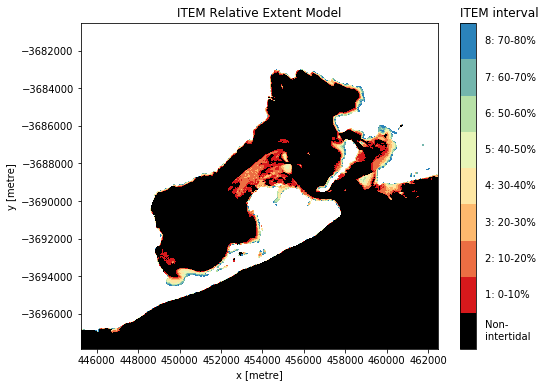

In [116]:
def plot_tides(ds):
    # Set up colour schemes and plot labels
    item_cs = ['black', '#d7191c', '#ec6e43', '#fdb96e', '#fee7a4', 
               '#e7f5b7', '#b7e1a7', '#74b6ad', '#2b83ba', 'white']
    labels = ['Non-\nintertidal', '1: 0-10%', '2: 10-20%', '3: 20-30%', 
              '4: 30-40%', '5: 40-50%', '6: 50-60%', '7: 60-70%', '8: 70-80%']

    # Plot ITEM Relative Extent Model
    item_plot = ds.plot(figsize=(8,6), levels=10, colors=item_cs, add_colorbar=False)
    plt.title('ITEM Relative Extent Model')

    # Add tidal interval percentages to colorbar
    cbar = plt.colorbar(item_plot)
    cbar.ax.get_yaxis().set_ticks([])
    cbar.ax.set_title('ITEM interval', loc = 'left')

    for j, label in enumerate(labels):
        cbar.ax.text(1.5, (j + 0.5) / 9.0, label, ha='left', va='center', color='black')
    cbar.ax.get_yaxis().labelpad = 15
    
plot_tides(item_data.relative)

### Masking out the outside of Franklin Harbour

The image returned by DEA contains data outside the Harbour and you are only interested in the data inside. You use the `mask()` function to create a binary mask defined by a polygon with the same extents and resolution of a `DataArray`. This mask is a 2-D numpy array that contains `0` for pixels outside the polygon and `1` for the pixels inside.

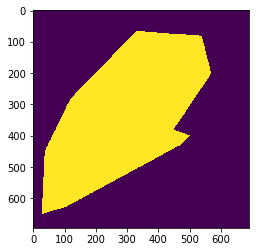

In [117]:
msk = mask(item_data.relative, poly)
plt.imshow(msk)

Now we apply this mask to the ITEM `DataArray` by multiplying (elementwise) the ITEM raster and the mask.

But there is a problem! The area outside the polygon gets assigned a `0`, which indicates "Non-intertidal", and we want this area to be marked with `9` instead. Can you figure out how to achieve this? **Hint:** *Reversing the mask with the logical not numpy `~` operator might be handy.*

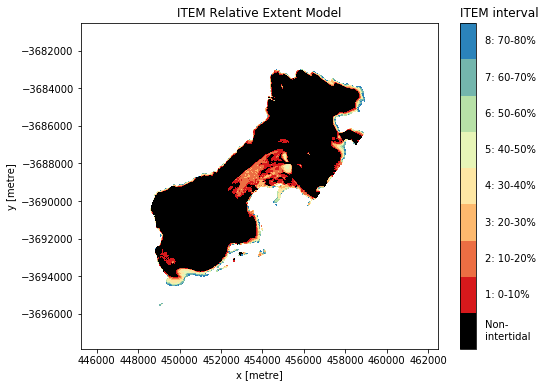

In [118]:
#item_data['relative'] = item_data['relative'] * msk 

###Solution:
item_data['relative'] = item_data['relative'] * msk + (~msk * 9)

plot_tides(item_data.relative)

In the DEA ITEM documentation you have found an interesting plot representing the correspondance between the `[1-8]` encoding in the product and the actual values of ocean height.

![image](http://dea-public-data.s3-ap-southeast-2.amazonaws.com/ITEM_Intervals/ITEM_REL_209_122.20_-18.07.jpg)

This is very handy and you start to figure out how useful these data is for your project. You decide to create a Python dictionary to map between ITEM values and actual ocean heights.

You then start by computing the total area of the harbour in square meters. **Hint:** *Each pixel represents a square area of 25 meters on the side.*

In [119]:
item_data['relative'] = item_data['relative'].astype(np.float32)
item_data['relative'] = item_data.relative.where(item_data.relative != 9, np.nan)

harbour_area = None

###Solution:
harbour_area = np.count_nonzero(~np.isnan(item_data.relative.data)) * 25 * 25

harbour_area

49408750

But you realise that not all this area gets filled with water in every tide. The numbers in ITEM represent the level of the sea at which an area gets exposed. 

You make the assumption that each day there are two complete tide cycles. You also estimate an average tide range of 4 meters for Cowell. In low tide the water is 2 meters below the mean sea level and in high tide is 2 meters above.

* The non-intertidal region `0` gets the whole 4 meters of tidal range.
* The areas represented with the largest value `8`, get exposed when the tide goes below +2 meters
* The areas represented with the next value `7`, get exposed when the tide goes below +1.75 meters
* ...
* The last value `1`, gets exposed at the lowest point of the tide, which is -2 meters.

Following this sequence you assign a coefficient to each tidal point representing the proportion of the total 4 meters range that each pixels experience.

The non-intertidal region `0` gets the whole 4 meters of tidal range, so its coefficient is `1`. For the rest of the values you assume a linear decrease in this coefficient mapping the values from `8` to `1` in `0.125` steps.

In [120]:
item_data['relative'] = item_data.relative.where(item_data.relative != 0, 1)

for i in range(8):
    item_data['relative'] = item_data.relative.where(item_data.relative != i+1, 0.125 + (i*0.125))

d = item_data.relative.data
print(np.nanmax(d))
print(np.nanmin(d))

np.unique(d[~np.isnan(d)])

1.0
0.125


array([0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ],
      dtype=float32)

You are finally ready to get the number of cubic metres *(1000 litres)* that flow in half tidal cycle. *From either hight to low tide and from low to high tide.*


In [121]:
# water_vol = coeff_sum * 4 metres depth * 25 meters wide * 25 meters height

water_vol = np.nansum(item_data.relative.data) * 4 * 25 * 25

print("The total water volume per half tidal cycle in Franklin Harbour is: {} m^3".format(water_vol))

The total water volume per half tidal cycle in Franklin Harbour is: 31413750.0 m^3


For converting this number to Watts you need to convert this number into a flow [litres/second].

High tides occur 12 hours and 25 minutes apart. It takes 6 hours and 12.5 minutes for the water at the shore to go from high to low, or from low to high. You decide to use the Datetime Python library to calculate the seconds in 6 hours and 12.5 minutes.

In [122]:
import datetime

half_cycle_secs = datetime.timedelta(hours=6,minutes=12,seconds=30).total_seconds()

print("The water flow at Franklin Harbour channels is: {} m^3/s".format(water_vol / half_cycle_secs))

The water flow at Franklin Harbour channels is: 1405.5369127516778 m^3/s


Finally you get the formula you've been given to transform this number into actual energy, which consist in dividing the flow by 45.5 to get KWatts.

In [123]:
print("The Franklin Harbour Tidal Power Plant would generate: {:0.2f} kWatts".format((water_vol / half_cycle_secs) / 45.5))

The Franklin Harbour Tidal Power Plant would generate: 30.89 kWatts


Congratulations! It's been an intense but productive day of work. You're about to get yourself a deserved coffee when you receive a call from the [Lake Illawarra](https://en.wikipedia.org/wiki/Lake_Illawarra) Authority in NSW. They have heard about your company's new tidal power plant technology and they reckon their location would be the perfect place to test it.

Can you do follow the same process to calculate how much Illawara Tidal Power Plant would generate?

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** September 2019

**Compatible `datacube` version:** 

In [124]:
print(datacube.__version__)

1.7+43.gc873f3ea.dirty


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)